In [1]:
import matplotlib.pyplot as plt
import procthor
from procthor.simulators import SceneGraphSimulator
from common import Pose
import object_search
from object_search.planners import PlanningLoop, OptimisticPlanner, LearnedPlanner, KnownPlanner, State
from object_search.planners.fluent import Fluent
from pathlib import Path

def get_args():
    args = lambda key: None  # noqa
    args.save_dir = '/data/test_logs'
    args.current_seed = 6
    args.resolution = 0.05
    args.do_save_video = True
    args.network_file = '/data/object_search/fcnn.pt'
    return args

def graphToFluents(graph):
    fluents = []
    for x in graph:
        if graph[x]["type"] == [0, 0, 1, 0]:
            string = "near robot " + graph[x]["id"]
            stringTwo = "at robot " + graph[x]["id"]
            fluents.append(~Fluent(string))
            fluents.append(~Fluent(stringTwo))
            # for y in graph:
            #     if graph[y]["type"] == [0, 0, 0, 1]:
            #         string = f"at {graph[y]['id']} {graph[x]['id']}"
            #         fluents.append(Fluent(string))
    fluents.append(Fluent("at plate|8|15 armchair|2|2|0"))
    fluents.append(Fluent("at pillow|2|0|1 bed|2|0|0"))
    return fluents
    
def test_object_search_learned_planner():
    '''Test object search in ProcTHOR environment with OptimisticPlanner'''
    predictor = {
                'sink|3|1|0': {
                    'faucet|3|1|1':1

                },
                
                'armchair|2|2|0':{
                    'plate|8|15':1,
                    'mug|8|17': 0
                },

                'diningtable|2|3|0': {
                    'plate|8|15':0
                },

                'bed|2|0|0':{
                    'pillow|2|0|1':1,
                    'blanket|2|0|2':1
                },
                
            }

    args = get_args()
    thor_interface = procthor.ThorInterface(args)
    known_graph, known_grid, robot_pose, target_obj_info = thor_interface.gen_map_and_poses()

    fluents = graphToFluents(known_graph.nodes)
    visited = []
    
    robot_pose = Pose(180, 190)
    learned_simulator = SceneGraphSimulator(known_graph,
                                            args,
                                            target_obj_info,
                                            known_grid,
                                            thor_interface)
    learned_robot = object_search.robot.Robot(robot_pose)
    learned_planner = OptimisticPlanner(target_obj_info, args, known_graph, known_grid)
    learned_planning_loop = PlanningLoop(target_obj_info, learned_simulator, learned_robot, args=args)
    
    for _, step_data in enumerate(learned_planning_loop):
        learned_planner.update(
            step_data['observed_graph'],
            step_data['observed_grid'],
            step_data['subgoals'],
            step_data['robot_pose'])
        print(step_data['observed_graph'].nodes)
        state = State((step_data['robot_pose'].x , step_data['robot_pose'].y), step_data['observed_graph'].nodes, set(), visited, fluents, predictor, False)
        print(state.fluents, 'hi')
        chosen_subgoal = learned_planner.compute_selected_subgoal()
        learned_planning_loop.set_chosen_subgoal(chosen_subgoal)
        for x in step_data['observed_graph'].nodes:
            if step_data['observed_graph'].nodes[x]["type"] == [0, 0, 1, 0] and step_data['observed_graph'].nodes[x]['position'] == chosen_subgoal.pose:
                visited.append(step_data['observed_graph'].nodes[x]['id'])
        print(visited)
        
    learned_cost, learned_trajectory = object_search.utils.compute_cost_and_trajectory(known_grid,
                                                                                       learned_robot.all_poses)
    cost, trajectory = object_search.utils.compute_cost_and_trajectory(known_grid, learned_robot.all_poses)
    # print(known_graph.nodes)
    plt.figure(figsize=(8, 8))
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")
    ax = plt.subplot(221)
    plt.title('Whole scene graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)
    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot_pose.x, robot_pose.y, '+', color='red', size=6, rotation=45)
    plt.title('Graph over occupancy grid')
    plt.subplot(223)
    top_down_image = learned_simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down view of the map')
    plt.axis('off')
    plt.subplot(224)
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, learned_robot.all_poses, trajectory, known_graph)
    plt.title(f"Cost: {cost:0.3f}")
    # print('testing')

-----------Using cached procthor data-----------
Target object: faucet
Known locations: ['sink']
Counter: 0 | Count since last turnaround: 100
{0: {'id': 'Apartment|0', 'name': 'apartment', 'position': (0, 0), 'type': [1, 0, 0, 0]}, 1: {'id': 'room|2', 'name': 'bedroom', 'position': (157, 87), 'type': [0, 1, 0, 0]}, 2: {'id': 'room|3', 'name': 'bathroom', 'position': (43, 72), 'type': [0, 1, 0, 0]}, 3: {'id': 'bed|2|0|0', 'name': 'bed', 'position': (181, 49), 'type': [0, 0, 1, 0]}, 4: {'id': 'dresser|2|1', 'name': 'dresser', 'position': (189, 190), 'type': [0, 0, 1, 0]}, 5: {'id': 'armchair|2|2|0', 'name': 'armchair', 'position': (193, 50), 'type': [0, 0, 1, 0]}, 6: {'id': 'diningtable|2|3|0', 'name': 'diningtable', 'position': (128, 87), 'type': [0, 0, 1, 0]}, 7: {'id': 'chair|2|3|1', 'name': 'chair', 'position': (127, 88), 'type': [0, 0, 1, 0]}, 8: {'id': 'chair|2|3|2', 'name': 'chair', 'position': (133, 74), 'type': [0, 0, 1, 0]}, 9: {'id': 'chair|2|3|3', 'name': 'chair', 'position'

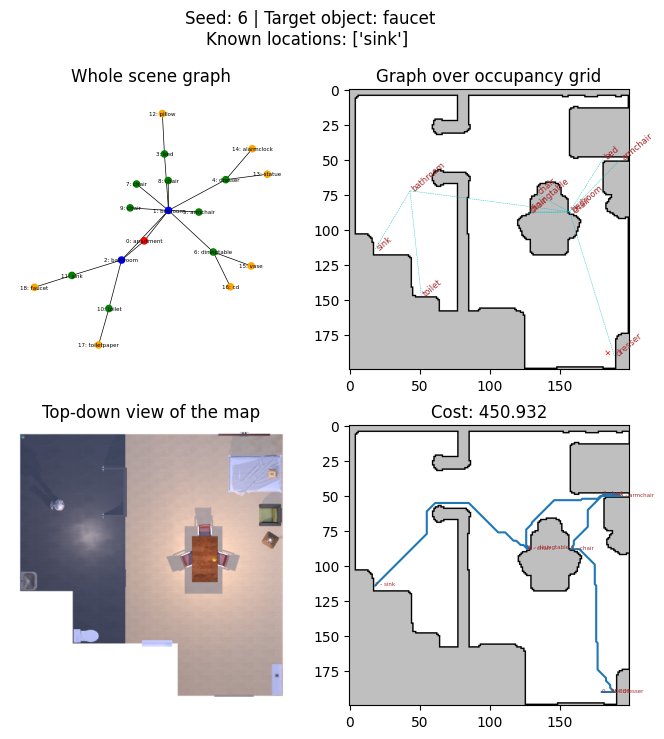

In [2]:
test_object_search_learned_planner()